In [113]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, scipy.sparse, seaborn as sns

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm  import LinearSVC, SVC

In [3]:
data = pd.read_csv("IA3-train.csv")
val_data = pd.read_csv("IA3-dev.csv")

In [4]:
def preprocessing_data(data, countvectorized:bool=False, sentiment:bool=True, testing:bool=False, val=None):
#If sentiment is true, it checks for positive sentiment
   #Find the index for the positive and negative data 
    def find_index(data):
        positive = []
        negative = []
        for i in range(1, len(data)):
            if data["sentiment"][i]==1:
                positive.append(i)
            else:
                negative.append(i)
        return positive, negative

    #Find the top 10 words
    def find_max_word(indexes, vector_of_words, name_of_words):
        num_words = vector_of_words.shape[1]
        array_word = np.zeros(num_words)
        for index in indexes:
            array_word += vector_of_words[index]
        common_word_index = sorted(range(len(array_word)), key=lambda i: array_word[i], reverse=True)[:10]
        word = name_of_words[common_word_index]
        return word
    
    positive, negative = find_index(data)
    
    if sentiment:
        check = positive
    else:
        check = negative
    
    if countvectorized:
        vectorizer = CountVectorizer(lowercase=True)
        bow = vectorizer.fit_transform(data["text"])
        vectors = bow.toarray()
        words = vectorizer.get_feature_names_out()
        top_words = find_max_word(check, vectors, words)
    else:
        vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
        bow = vectorizer.fit_transform(data["text"])
        vectors = bow.toarray()
        words = vectorizer.get_feature_names_out()
        top_words = find_max_word(check, vectors, words)
    
    if testing:
        bow = vectorizer.transform(val_data["text"])
        vectors = bow.toarray()
        return vectors
           
        
    return top_words, vectors

In [5]:
top_words_tfid = preprocessing_data(data, countvectorized=True)[0]
top_words_tfid

array(['the', 'to', 'you', 'for', 'thanks', 'jetblue', 'southwestair',
       'united', 'thank', 'and'], dtype=object)

In [6]:
top_words_common = preprocessing_data(data, countvectorized=True, sentiment=False)[0]
top_words_common

array(['to', 'the', 'flight', 'united', 'on', 'and', 'you', 'for', 'my',
       'usairways'], dtype=object)

In [90]:
def blanket(data, val_data):
    y_train = data["sentiment"] 
    y_val = val_data["sentiment"]
    tfid_vectors = scipy.sparse.csr_matrix(preprocessing_data(data)[1])
    val_vectors = scipy.sparse.csr_matrix(preprocessing_data(data, testing=True, val = val_data))
    return y_train, y_val,tfid_vectors, val_vectors

In [164]:
def linear_validate(data, val_data, cs):
    y_train, y_val,train_vectors, val_vectors = blanket(data, val_data)
    support = np.zeros(len(cs))
    scores = np.zeros(len(cs))
    for (i, c) in enumerate(cs):
        clf = LinearSVC(C=c)
        clf.fit(train_vectors, y_train)
        decision_function = clf.decision_function(train_vectors)
        support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
        scores[i] = clf.score(val_vectors, y_val)
        support[i] = len(support_vector_indices)
    return scores, support

In [92]:
c = [10**i for i in range(-4,5)]

In [94]:
acc, support = linear_validate(data, val_data, c)

C:\Users\gbeng\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gbeng\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gbeng\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [185]:
def plot_support(support, cs, name="", axis="C"):
    fig, ax = plt.subplots()
    plt.plot(np.log10(cs), support)
    plt.xlabel(f"log({axis})")
    plt.ylabel("# of support vectors")
    plt.title(name)
    plt.savefig(name, bbox_inches='tight')
    plt.show()

In [186]:
def plot_acc(acc, cs, name=""):
    fig, ax = plt.subplots()
    plt.plot(np.log10(cs), acc)
    plt.xlabel("log(C)")
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.savefig(name, bbox_inches='tight')
    plt.show()

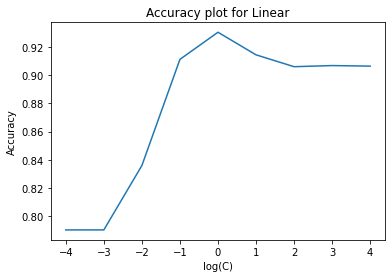

In [194]:
plot_acc(acc, c, "Accuracy plot for Linear")

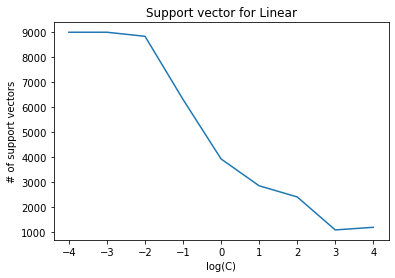

In [188]:
plot_support(support, c, "Support vector for Linear")

In [17]:
new_c = [10**i for i in np.linspace(-1, 1, 10)]

In [18]:
new_acc, new_support = linear_validate(data, val_data, new_c)

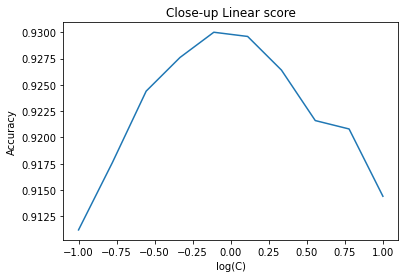

In [195]:
plot_acc(new_acc, new_c, "Close-up Linear score")

In [165]:
def quad_validate(data, val_data, cs):
    y_train, y_val,train_vectors, val_vectors = blanket(data, val_data)
    scores = np.zeros(len(cs))
    support = np.zeros(len(cs))
    for (i, c) in enumerate(cs):
        clf = SVC(C=c, kernel='poly', degree=2)
        clf.fit(train_vectors, y_train)
        scores[i] = clf.score(val_vectors, y_val)
        support[i] = sum(clf.n_support_)
    return scores, support

In [97]:
scores, support_quad = quad_validate(data, val_data, c)

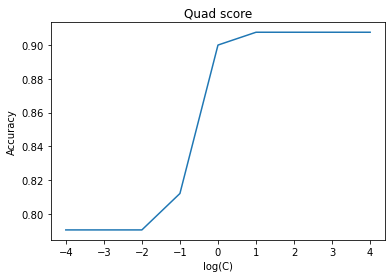

In [190]:
plot_acc(scores, c, "Quad score")

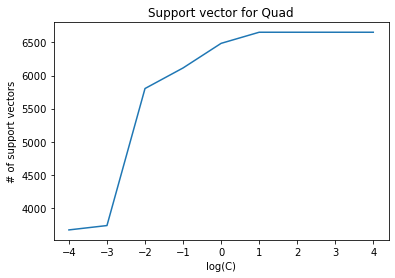

In [191]:
plot_support(support_quad, c, "Support vector for Quad")

In [101]:
γ =[10**i for i in range(-5, 2)]

In [171]:
def rbf_validate(data, val_data, cs, γs, fixed_c:bool=False, fixed_γ:bool=False):
    y_train, y_val,train_vectors, val_vectors = blanket(data, val_data)
    training_acc_grid = np.zeros((len(γs), len(cs)))
    val_acc_grid     = np.zeros((len(γs), len(cs)))
    
    if fixed_c:
        supports = np.zeros(len(γs))
        for (i, γ) in enumerate(γs):
            svm = SVC(kernel="rbf", gamma=γ, C=10)
            svm.fit(train_vectors, y_train)
            supports[i] = sum(svm.n_support_)
        return supports
    elif fixed_γ:
        supports = np.zeros(len(cs))
        for (i, c) in enumerate(cs):
            svm = SVC(kernel="rbf", gamma=0.1, C=c)
            svm.fit(train_vectors, y_train)
            supports[i] = sum(svm.n_support_)
        return supports
    else:
        for (j, γ) in enumerate(γs):
            for (i, c) in enumerate(cs):
                clf = SVC(kernel="rbf", gamma=γ, C=c)
                clf.fit(train_vectors, y_train)
                training_acc_grid[len(γs)-j-1, i] = clf.score(train_vectors, y_train)
                val_acc_grid[len(γs)-j-1, i] = clf.score(val_vectors, y_val)     
        return training_acc_grid, val_acc_grid

In [166]:
def plot_heatmap(grid, γs, cs, name=""):
    temp_γs = γs[::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    heat_map = sns.heatmap(grid, linewidth = 1 , cbar = True, xticklabels=np.log10(cs), yticklabels=np.log10(temp_γs), annot=True, fmt=".3f")
    plt.xlabel("log(c)")
    plt.ylabel("log(γ)")
    plt.savefig(name)
    plt.title(name)
    plt.show()

In [141]:
train_scores, val_scores= rbf_validate(data, val_data, c, γ)

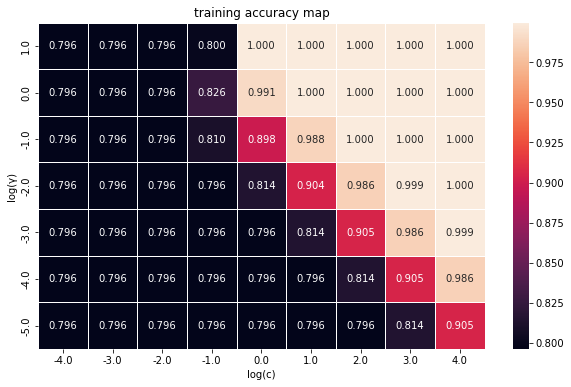

In [161]:
plot_heatmap(train_scores, γ, c, "training accuracy map")

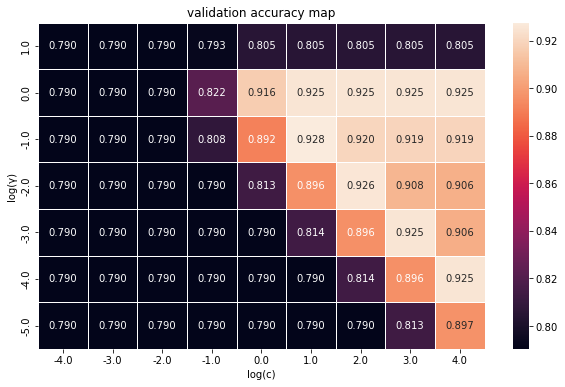

In [162]:
plot_heatmap(val_scores, γ, c, "validation accuracy map")

In [177]:
fixed_c = rbf_validate(data, val_data, c, γ, fixed_c=True)

In [173]:
fixed_γ = rbf_validate(data, val_data, c, γ, fixed_γ=True)

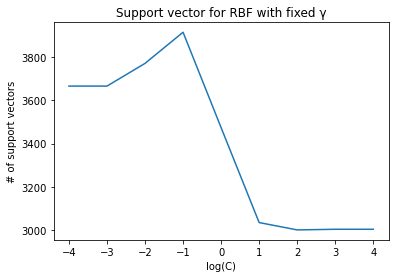

In [192]:
plot_support(fixed_γ, c, name="Support vector for RBF with fixed γ")

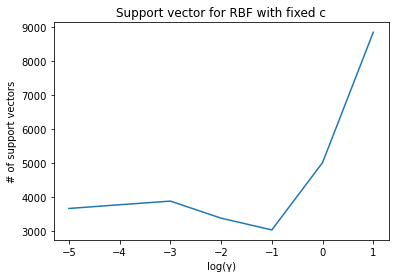

In [193]:
plot_support(fixed_c, γ, axis="γ", name="Support vector for RBF with fixed c")